# <u>INTERACTIVE GUIDE</u>
## Imposing a biopsy transcriptome onto the myositis network architecture and running the neural network

This is the process for converting a biopsy transcriptome into a network image to explore in Cytoscape, and then feeding that transcriptome image to the neural network described in Amici et al., 2021.

Paper link: 

Contact for questions: david.amici@northwestern.edu


### 1. Import necessary modules and prepare the transcriptome data

It is suggested that you use your own control patients where possible. If not, it is likely that batch effects - related to sequencing or processing parameters - may contribute to the differences between your patient(s) and our controls, and thus affect how the network appears. However, if this is not possible, use our controls and follow the processing pipeline below. You can also compare vs. our myositis patients as discussed below.

As a side note, if you are new to coding/Python, comments hide behind the # symbol. Use the comments to understand what each line does. You will likely need to install some packages. Anaconda (https://www.anaconda.com/products/individual) is a good source for most of them. Otherwise use the terminal as needed, pip install module_name. Finally, as some things will almost certainly fail due to updates to packages (etc.), be sure to Google your error message! Chances are you will find the answer. If not, email me!

In [1]:
## Import necessary modules
import pandas as pd
import numpy as np

# to remove blank gray space at the edges of notebook, remove if desired
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
display(HTML("<style>.output_result { max-width:98% !important; }</style>"))

In [2]:
### Process the transcriptome data for loading into Cytoscape

### median log2(FPKM+1) of our control patients, or replace with yours
control = pd.read_csv('median_control_exp.csv', index_col=0)

### if you want to compare with myositis patients on average instead of normal
### controls, run the following code to change what is normalized to.
# control = pd.read_csv('median_myositis_exp.csv', index_col=0)


### input a FPKM file, or use ours as an example
input_patient = pd.read_csv('mi2_example_exp.csv', index_col=0)


###Name the patient
name = 'Example'
input_patient.columns = [name]

### ours is in log2(FPKM+1) format already, if yours is just FPKM, run the following
# input_patient = np.log2(input_patient+1)

### generate relative expression profile
input_patient =  control.join(input_patient)
input_patient[name] = input_patient[name] - input_patient.control
input_patient = input_patient[[name]]
input_patient.to_csv('{}_rel_exp.csv'.format(name))

print('Relative expression profile saved as {}_rel_exp.csv\n'.format(name))
print('Example DEG: (L2FC)')
input_patient.sort_values(by=name, ascending=False).head()

Relative expression profile saved as Example_rel_exp.csv

Example DEG: (L2FC)


,Example
RPL26,7.688068
IFI6,6.756401
ISG15,6.664723
MYBPH,5.957776
RPL27,5.814963


## 2. Load into the network (Cytoscape)

First, if you haven't already downloaded cytoscape: https://cytoscape.org/

Next, load our Cytoscape session file (myositis.cys) from either GitHub or the associated publication. It will take a while to load the first time.

You should now see the network as described in the manuscript. To overlay your custom expression profile (or ot view that of other groups discussed in the manuscript), go to the style tab (brown circle below). Make sure that "node" is selected (bottom menu).

The color on the network represents a simple mapping where 0 log2 fold change is white (no change) and positive and negative changes are red and blue, respectively. Thus, you will tell cytoscape that you want the nodes colored based on your expression profile using the fill color mapping option (blue circle below). Choose the column of your session - here, whatever you've named your patient. Wait a few seconds, and the network will be colored based on your custom biopsy! 

Search for individual genes of interest using search bar (brown circle). To look at a pathway/module of interest from the manuscript or the associated excel files with all of the modules listed, 

Or, if you want to use the neural network, proceed to the next section.

<img src="example_cys.png" alt="Drawing" style="width: 800px;"/>

## 3. Use the myositis neural network

The input format for the network is a simple image of your network as viewed in cytoscape, as described above. With how much data is stored in each network, Cytoscape's exporting functions do not work well for this purpose. So, the easiest way is to simply enlarge your window to the extent possible and take a screenshot (save as .jpg). 

An example image is below - the image doesn't need to exactly perfect, but try to have the legs of the square be close to the edges of the network without cutting off any genes.


<img src="example_DM.jpg" alt="Drawing" style="width: 300px;"/>


At this point, you're ready to input your biopsy into the neural network. The code below will generate the model, load the weights from our training and validation data, and then analyze your image.

In [3]:
### Generate the model

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # convert 3D feature maps --> 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))   

# COMPILE
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', #adam #sgd
              metrics=['accuracy'])


### Load the weights from training/validation by Amici et al.

model.load_weights("classify_5_500_epochs_than_retrain_50.h5")
#newest version of h5py doesn't play well with tensorflow seemingly, see
#https://github.com/tensorflow/tensorflow/issues/44467. I used yan12125's solution

Now you can run the model with your input image (or ours, as an example).

This can give an estimated diagnosis.

In [4]:
### Input the name (path) to your image, or use our example
image_path = 'example_DM.jpg'

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
img = load_img(image_path, target_size=(300,300))
x = img_to_array(img)  # this is a Numpy array with shape (300, 300, 3)
your_array = x.reshape((1,300,300,3))  # this is a Numpy array with shape (1, 300, 300, 3)

labels = ['Anti-Synthetase Syndrome', 'Dermatomyositis', 'Inclusion body myositis', 
          'Immune-Mediated Necrotizing Myopaty', 'Normal (non-myositis)']

group_pred = labels[model.predict(your_array).argmax(axis=-1)[0]]

print('The network would classify this biopsy as: \n\n{}'.format(group_pred))

print('\n****')

The network would classify this biopsy as: 

Dermatomyositis

****


Recall, however, that the purpose of our neural network is not to serve as a universal diagnostic tool. Our groups were imbalanced (i.e., more of one class than another) and we had relatively few patients overall.

<u>Thus: use of the network as a diagnostic tool cannot be recommended without further study and likely additional training using an external dataset.</u>

However, the predictions can be intriguing and may help us think about individual biopsies. To extract the feature-level insights from your dataset, similar to how we organize patients in our manuscript, run the code below.

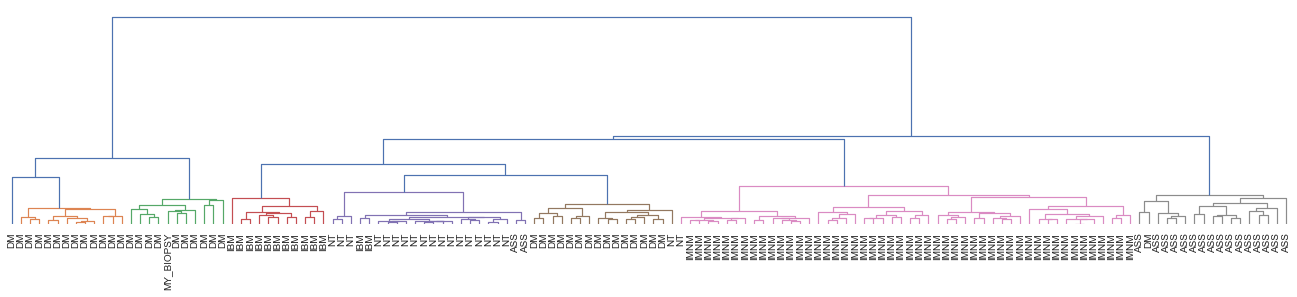

In [8]:
#import modules
from keras.models import Model
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

#Pare down model to stop at features step
just_features = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
#Images generated in our study
net_features = pd.read_csv('features_from_our_patients.csv', index_col=0)

your_features = just_features.predict(your_array)
net_features = net_features.append(pd.DataFrame(your_features, columns=net_features.columns, index=['MY_BIOPSY']))


linkage = sch.linkage((net_features), method  = "ward", optimal_ordering=True)
sns.set(font_scale=1, context='paper', font="Arial", style='white')
dend1 = sch.dendrogram(linkage,leaf_rotation=90, leaf_font_size=8, color_threshold=15000,
                       labels=net_features.index
                      )
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_yticklabels([])
plt.gcf().set_size_inches(23,4)
sns.despine(left=True, bottom=True)
plt.show(); plt.close()

This tells us that the patient - here, an example DM patient - fits best within the DM cluster. Cross referencing with the manuscript reminds us that this is the DM-severe cluster.